In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import keras
import numpy as np

In [2]:
train_path = "Spectrgraph/train"
valid_path = "Spectrgraph/val"

In [3]:
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 366 images belonging to 5 classes.


In [6]:
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 91 images belonging to 5 classes.


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Model

# Define the input shape and load the ResNet50 model
num_classes = len(train_generator.class_indices)
input_shape = (224, 224, 3)
resnet_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=input_shape))

# Freeze the ResNet layers to keep their weights fixed
for layer in resnet_model.layers:
    layer.trainable = False

# Create the LSTM model
x = TimeDistributed(Flatten())(resnet_model.output)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=resnet_model.input, outputs=output)


In [8]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(lr=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
# Define the number of epochs and batch size
epochs = 5
batch_size = 32

# Fit the model
history = model.fit(
    train_generator,  # Use your generator here
    epochs=epochs,
    validation_data=valid_generator,
    batch_size=batch_size
)


Epoch 1/5
12/12 [==============================] - 129s 7s/step - loss: 0.8511 - accuracy: 0.7678 - val_loss: 0.6692 - val_accuracy: 0.8352
Epoch 2/5
12/12 [==============================] - 67s 6s/step - loss: 0.6812 - accuracy: 0.8361 - val_loss: 0.6670 - val_accuracy: 0.8352
Epoch 3/5
12/12 [==============================] - 67s 6s/step - loss: 0.6727 - accuracy: 0.8361 - val_loss: 0.6681 - val_accuracy: 0.8352
Epoch 4/5
12/12 [==============================] - 65s 5s/step - loss: 0.6951 - accuracy: 0.8361 - val_loss: 0.6665 - val_accuracy: 0.8352
Epoch 5/5
12/12 [==============================] - 59s 5s/step - loss: 0.6894 - accuracy: 0.8361 - val_loss: 0.6710 - val_accuracy: 0.8352


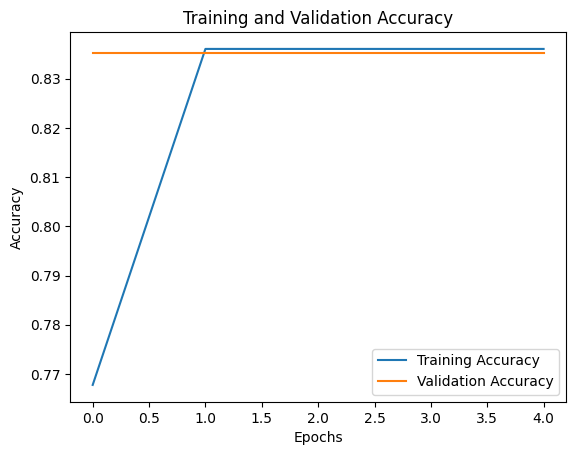

In [10]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

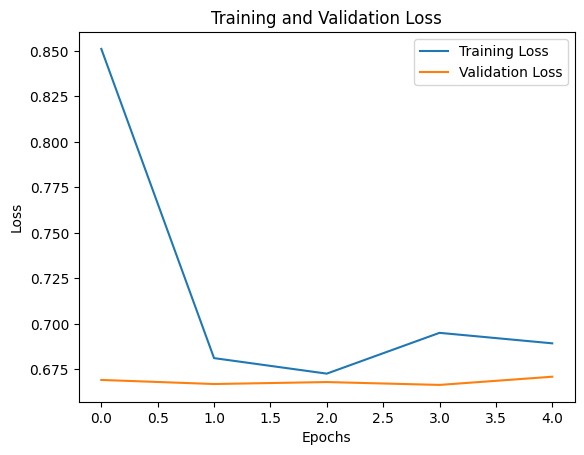

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [12]:
# Make predictions on test data
test_loss, test_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model.save("trained_model_lstm.h5")
print("Trained model saved as 'trained_model_lstm.h5'")

3/3 [==============================] - 7s 2s/step - loss: 0.6710 - accuracy: 0.8352
Test Loss: 0.6710
Test Accuracy: 0.8352
Trained model saved as 'trained_model_lstm.h5'


1/1 [==============================] - 0s 220ms/step


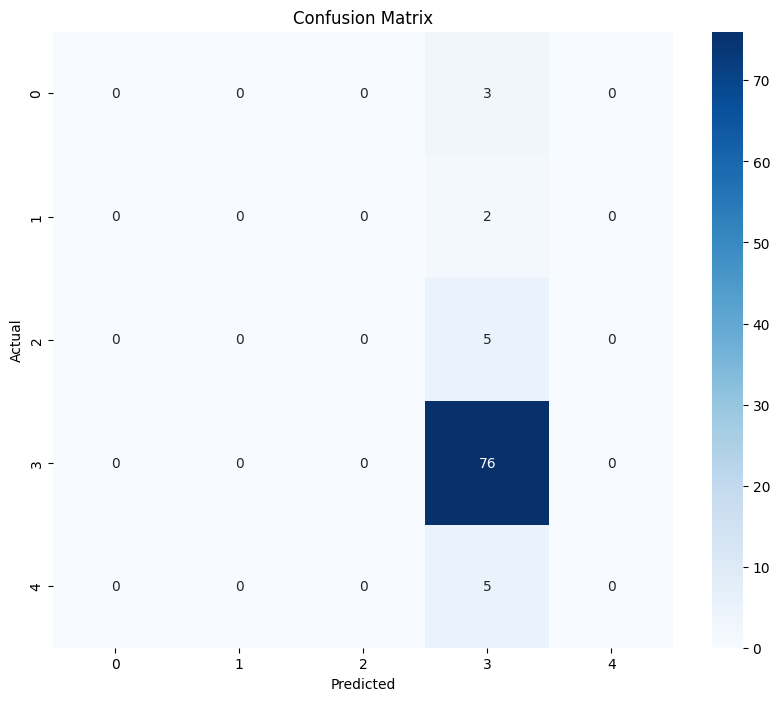

In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
# Load the saved model
loaded_model = tf.keras.models.load_model("trained_model.h5")

# Initialize variables
num_samples = len(valid_generator.filenames)
batch_size = 32
num_batches = int(np.ceil(num_samples / batch_size))
all_test_labels = []
all_predicted_labels = []

# Generate predictions in batches
for _ in range(num_batches):
    batch_images, batch_labels = next(valid_generator)
    batch_predictions = loaded_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    all_test_labels.extend(np.argmax(batch_labels, axis=1))
    all_predicted_labels.extend(batch_predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(all_test_labels, all_predicted_labels)

# Plot the confusion matrix
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()